In [1]:
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
from astropy.coordinates import SkyCoord

from plato.field import find_targets
from plato.visualisation import set_plot_defaults

In [2]:
field = "LOPN1"

In [3]:
# data_all_sky = pl.read_csv("../data/processed/all_sky_targets.csv")

# # add n_cameras column for field
# data = find_targets(
#     data_all_sky,
#     field = field,
# )
# print(f"Number of targets found in field {field}: {(data["n_cameras"] > 0).sum()}")
# data.filter(data["n_cameras"] > 0).write_csv(f"../data/processed/{field}_targets.csv")

In [4]:
data = pl.read_csv(f"../data/processed/{field}_targets.csv")

In [5]:
targets = (
    data.filter(data["n_cameras"] > 0)
    .select(["GLON", "GLAT", "n_cameras", "Population"])
    .to_pandas()
)
target_coords = SkyCoord(
    l=targets["GLON"],
    b=targets["GLAT"],
    unit="deg",
    frame="galactic",
)

## PLOT TARGETS

In [6]:
# set_plot_defaults()

figure_directory = f"../figures/03_plato_fields"
save = False

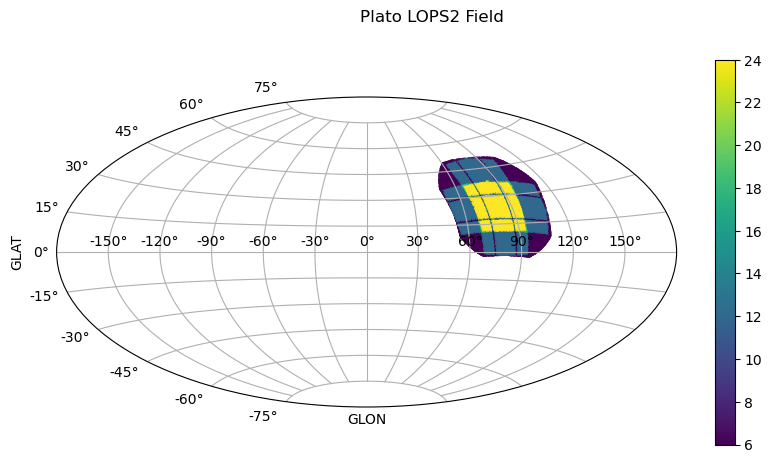

In [7]:
fig = plt.figure(figsize=(10, 5))
fig.suptitle("Plato LOPS2 Field")
ax = fig.add_subplot(111, projection="aitoff")
sc = ax.scatter(
    target_coords.l.wrap_at("180d").rad,
    target_coords.b.rad,
    c=targets["n_cameras"],
    cmap="viridis",
    s=0.01,
)
ax.grid()
ax.set_xlabel("GLON")
ax.set_ylabel("GLAT")
cbar = fig.colorbar(sc)

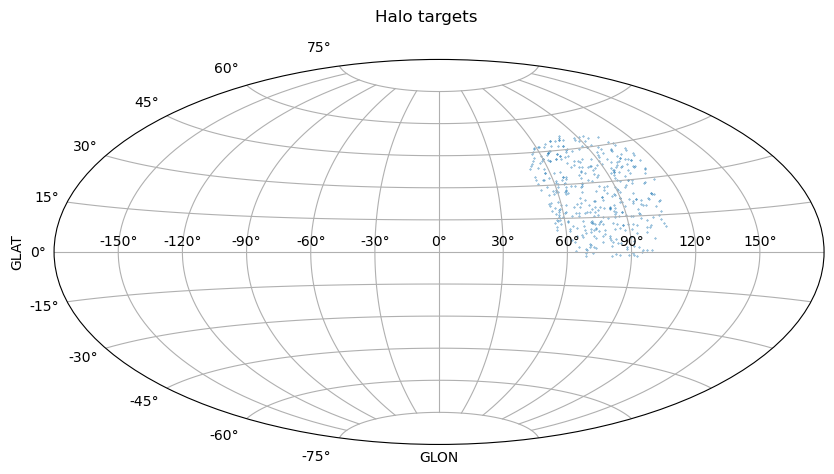

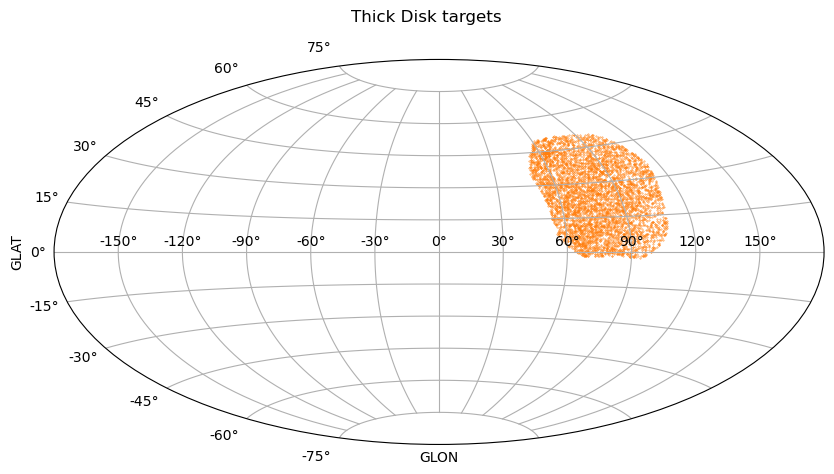

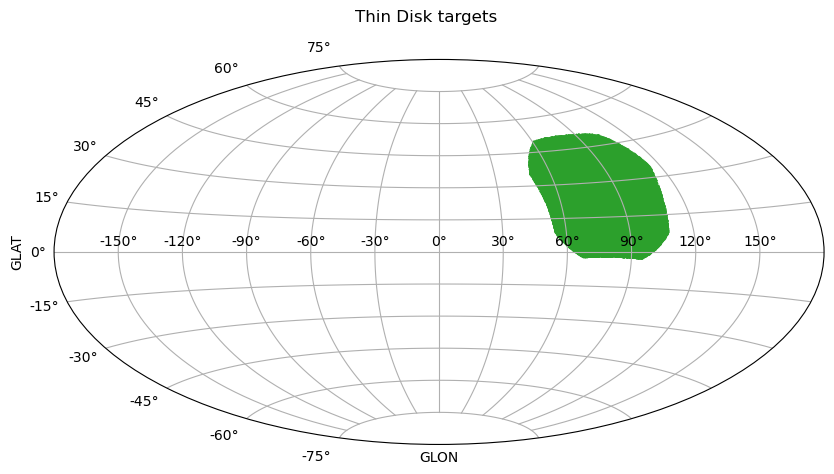

In [8]:
for i, population in enumerate(["Halo", "Thick Disk", "Thin Disk"]):
    coords = target_coords[targets["Population"] == population]

    fig = plt.figure(figsize=(10, 5))
    fig.suptitle(f"{population} targets")
    ax = fig.add_subplot(111, projection="aitoff")
    ax.scatter(
        coords.l.wrap_at("180d").rad,
        coords.b.rad,
        color=f"C{i}",
        s=0.1,
    )
    ax.grid()
    ax.set_xlabel("GLON")
    ax.set_ylabel("GLAT")